# Context
This notebook drives the training process for different models.

In [36]:
# Set project's environment variables
import os
import sys
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../project.env")
sys.path.append(os.environ["PYTHONPATH"])

In [37]:
# Import project-wide and PH2 specific variables and functions
import superheader as sup

In [38]:
TRAIN_classes = 'alpha-classes'
score_file = os.path.join(sup.TRAIN_SCORES_ROOT, TRAIN_classes, sup.TRAIN_KNN_CODE, "2025-06-08_23:19:42.csv")
top_barrier=5

# Score analysis

## Helper functions

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [40]:
def visualize(df, group_cols, top, filter_cols=None, filter_values=None):
    """
    Optionally filters df by filter_cols == filter_values, groups by group_cols,
    selects top `top` rows by accuracy, computes mean accuracy, and plots the result.
    """
    filter_desc = ""

    # Filter if needed
    if filter_cols and filter_values:
        for col, val in zip(filter_cols, filter_values):
            df = df[df[col] == val]
        filter_desc = " | " + " & ".join(f"{col}={val}" for col, val in zip(filter_cols, filter_values))

    # Group, take top `top` by accuracy, compute mean
    mean_accuracies = (
        df.groupby(group_cols)
          .apply(lambda g: g.sort_values('accuracy', ascending=False).head(top)['accuracy'].mean())
          .reset_index(name='mean_accuracy')
    )

    # Create simple string labels for the x-axis
    mean_accuracies['label'] = mean_accuracies[group_cols].astype(str).agg(' | '.join, axis=1)

    # Plot
    colors = sns.color_palette("muted", len(mean_accuracies))
    plt.figure(figsize=(10, 6))
    plt.bar(mean_accuracies['label'], mean_accuracies['mean_accuracy'], color=colors)

    plt.ylabel(f"Mean Accuracy (Top {top})")
    plt.title(f"Top {top} Mean Accuracies per {' + '.join(group_cols)}{filter_desc}")
    plt.xticks(rotation=45, ha='right')

    # Set y-limits with padding
    min_val = mean_accuracies['mean_accuracy'].min()
    max_val = mean_accuracies['mean_accuracy'].max()
    padding = (max_val - min_val) * 0.3  # 10% padding
    plt.ylim(max(min_val - padding, 0), min(max_val + padding, 1))

    # Add values on bars
    for i, val in enumerate(mean_accuracies['mean_accuracy']):
        plt.text(i, val + padding*0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


## Data

In [41]:
import pandas as pd

In [42]:
knn_scores_df = pd.read_csv(score_file)
knn_scores_df = knn_scores_df.fillna('None')
knn_scores_df.sort_values(by="accuracy", ascending=False)

,class_list,accuracy,data_unit,PH2,PH3,reducer,kernel,n,k
1354,alpha-classes,0.984765,AHpf,True,False,None,None,-1,5
1324,alpha-classes,0.984765,AHpf,True,True,kpca,cosine,15,5
1264,alpha-classes,0.984693,AHpf,True,True,pca,None,15,5
1352,alpha-classes,0.984621,AHpf,True,False,None,None,-1,3
1084,alpha-classes,0.984621,AHpf,True,True,pca,None,13,5
...,...,...,...,...,...,...,...,...,...
5602,alpha-classes,0.035593,Spv,True,True,kpca,sigmoid,2,8
5513,alpha-classes,0.035593,Spv,True,True,kpca,sigmoid,1,9
5518,alpha-classes,0.033898,Spv,True,True,kpca,sigmoid,1,14
5514,alpha-classes,0.032203,Spv,True,True,kpca,sigmoid,1,10


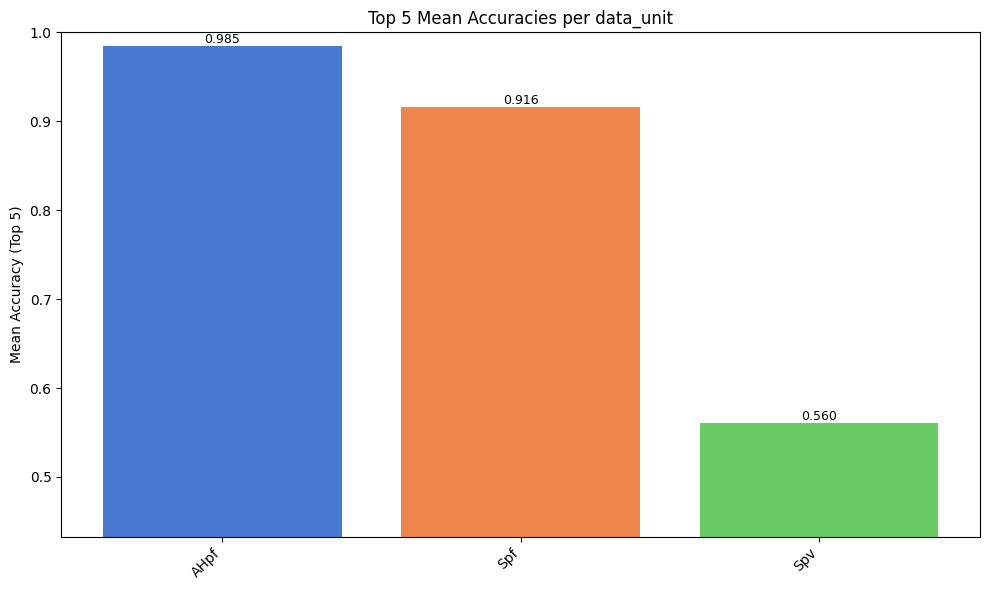

In [43]:
visualize(knn_scores_df, group_cols=['data_unit'], top=top_barrier)

### By data unit

#### Ahpf

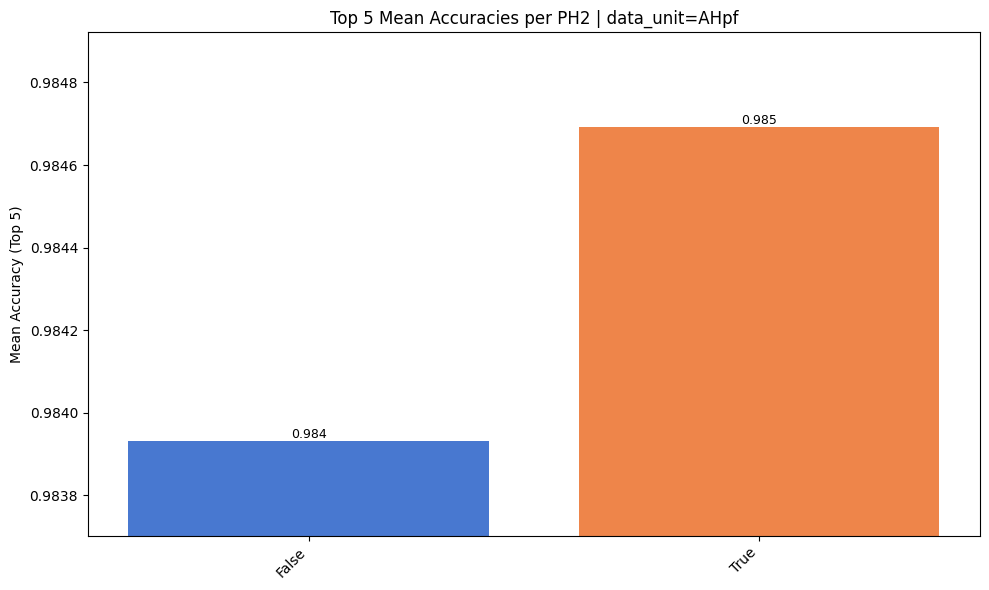

In [44]:
visualize(knn_scores_df, group_cols=['PH2'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

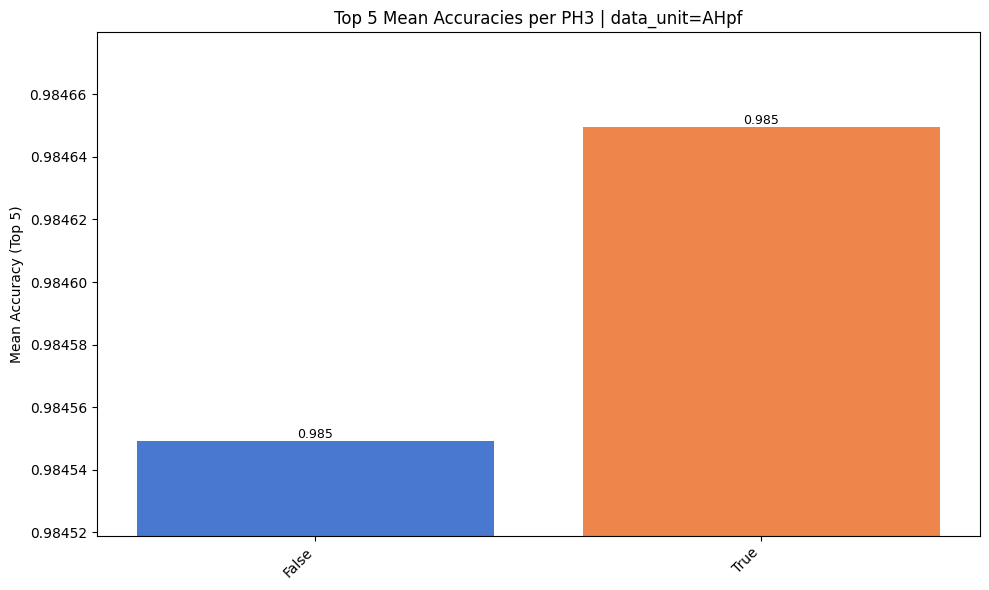

In [45]:
visualize(knn_scores_df, group_cols=['PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

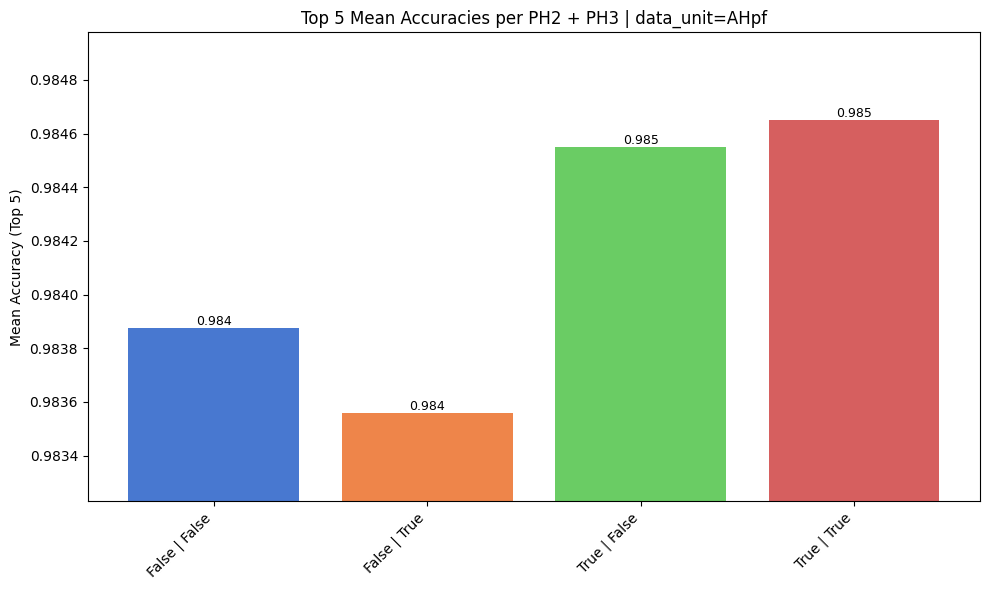

In [46]:
visualize(knn_scores_df, group_cols=['PH2', 'PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

#### Spf

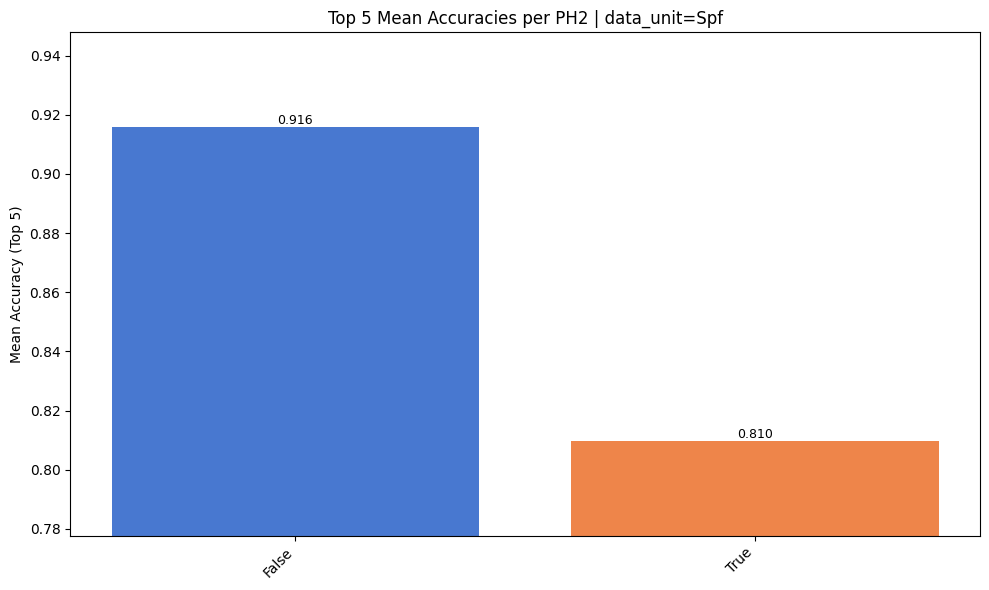

In [47]:
visualize(knn_scores_df, group_cols=['PH2'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

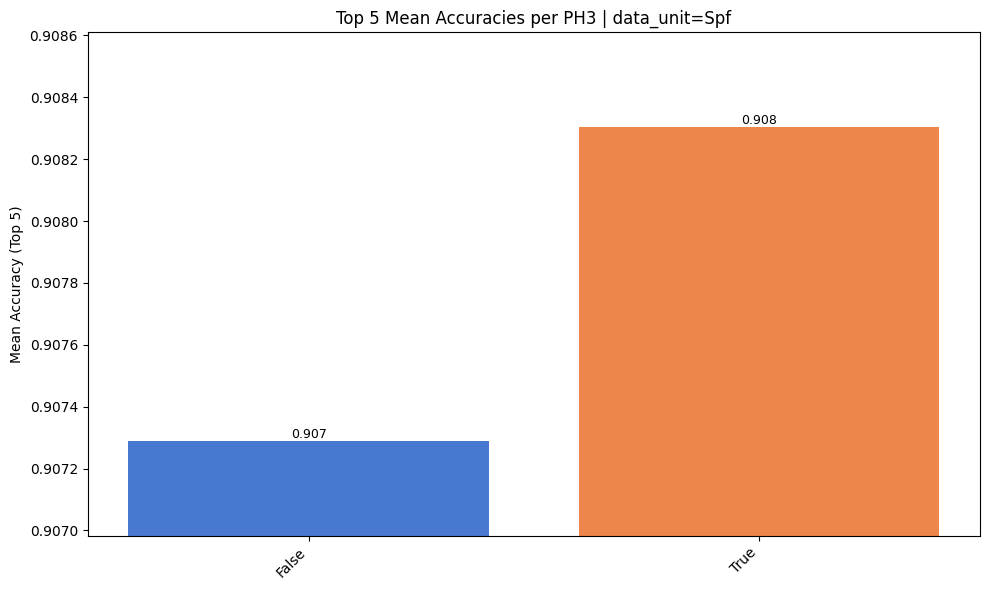

In [48]:
visualize(knn_scores_df, group_cols=['PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

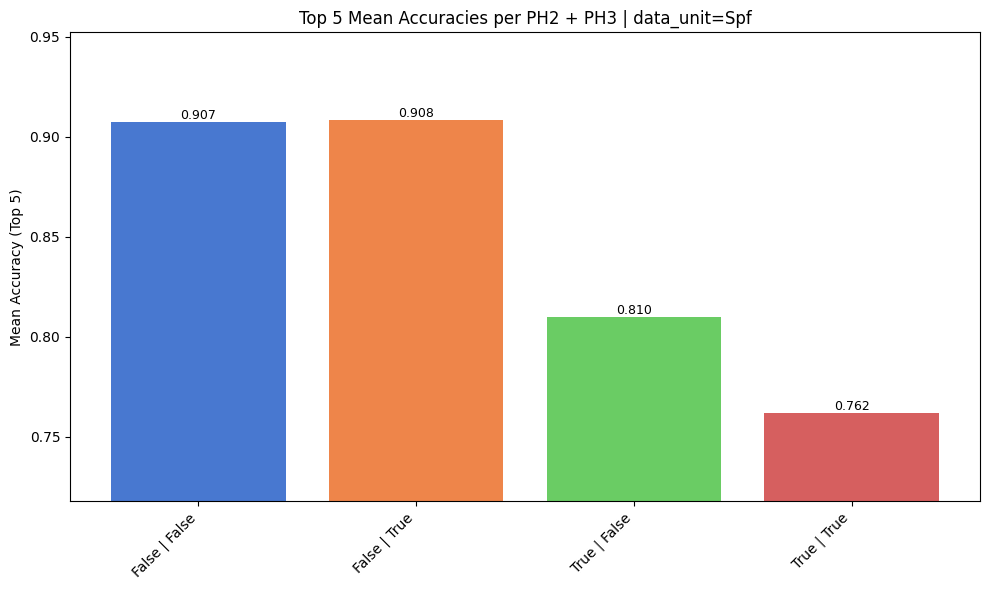

In [49]:
visualize(knn_scores_df, group_cols=['PH2', 'PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

#### Spv

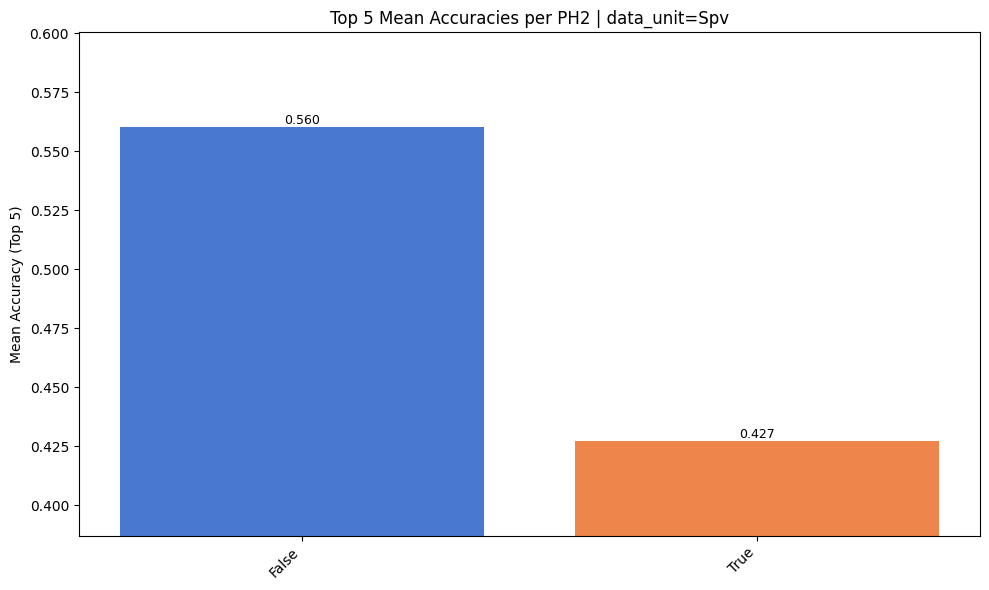

In [50]:
visualize(knn_scores_df, group_cols=['PH2'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

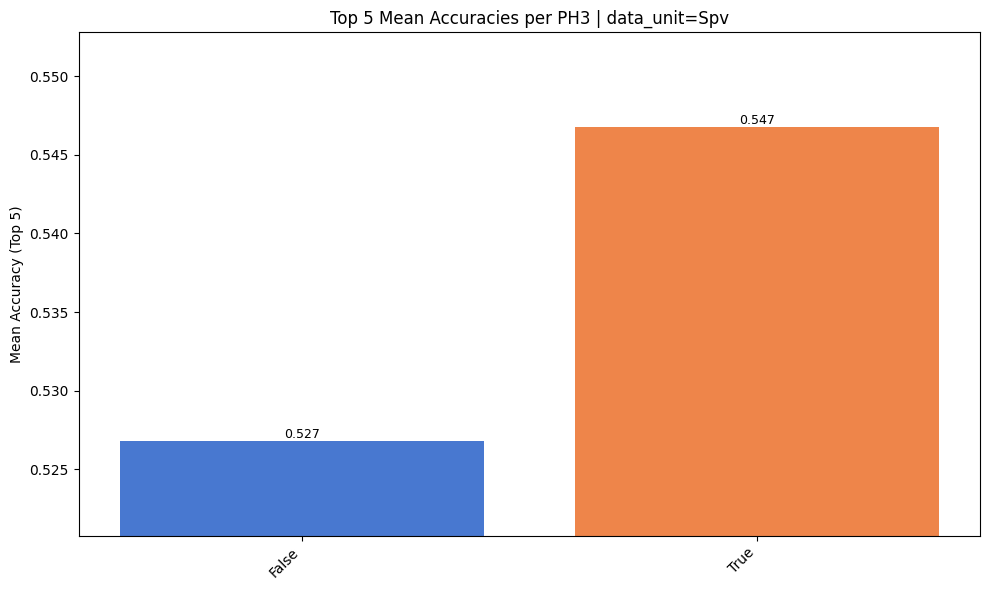

In [51]:
visualize(knn_scores_df, group_cols=['PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

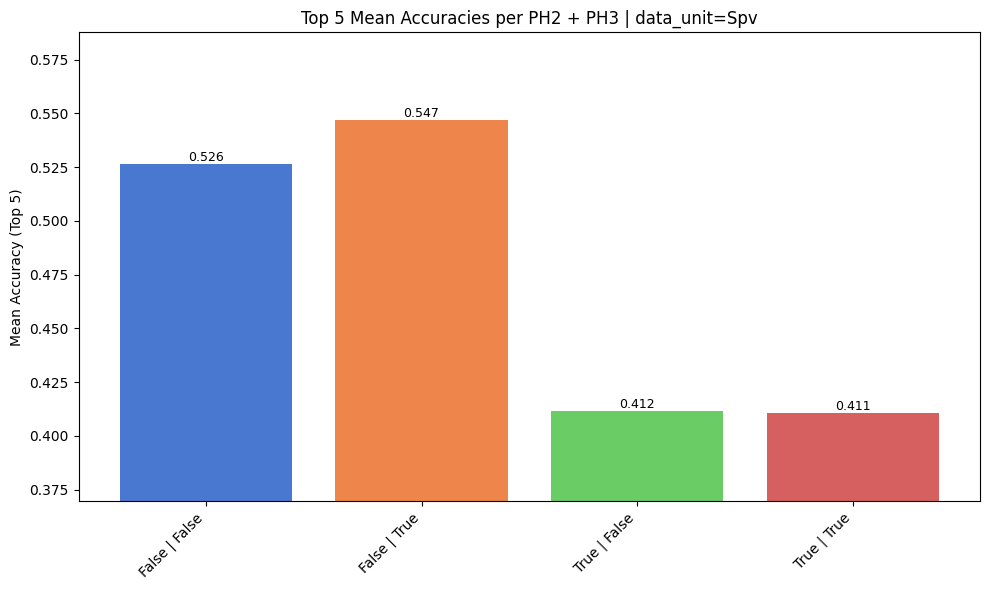

In [52]:
visualize(knn_scores_df, group_cols=['PH2', 'PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

### By reducer

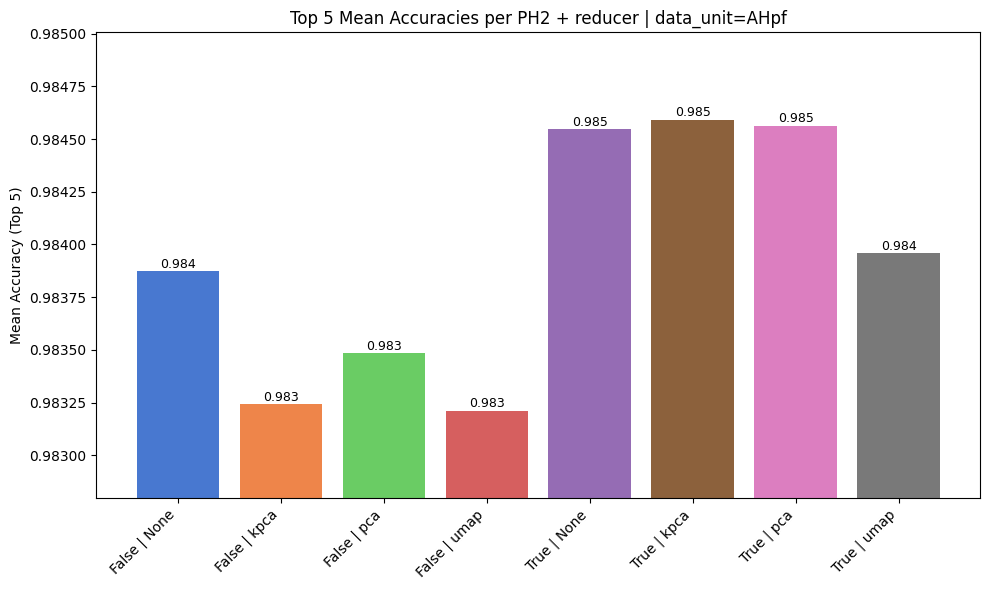

In [53]:
visualize(knn_scores_df, group_cols=['PH2', 'reducer'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

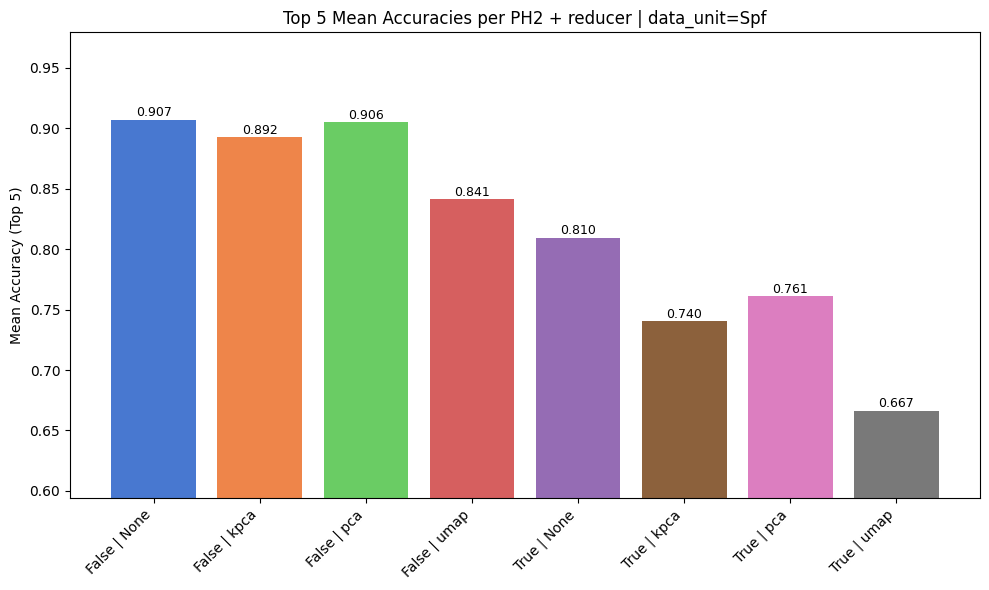

In [54]:
visualize(knn_scores_df, group_cols=['PH2', 'reducer'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

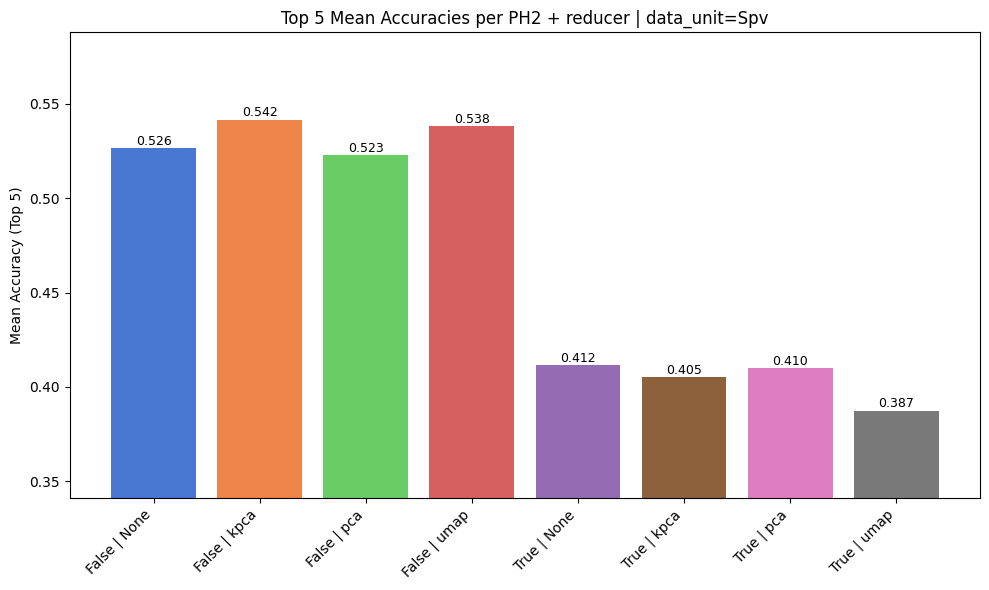

In [55]:
visualize(knn_scores_df, group_cols=['PH2', 'reducer'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

### By kernel

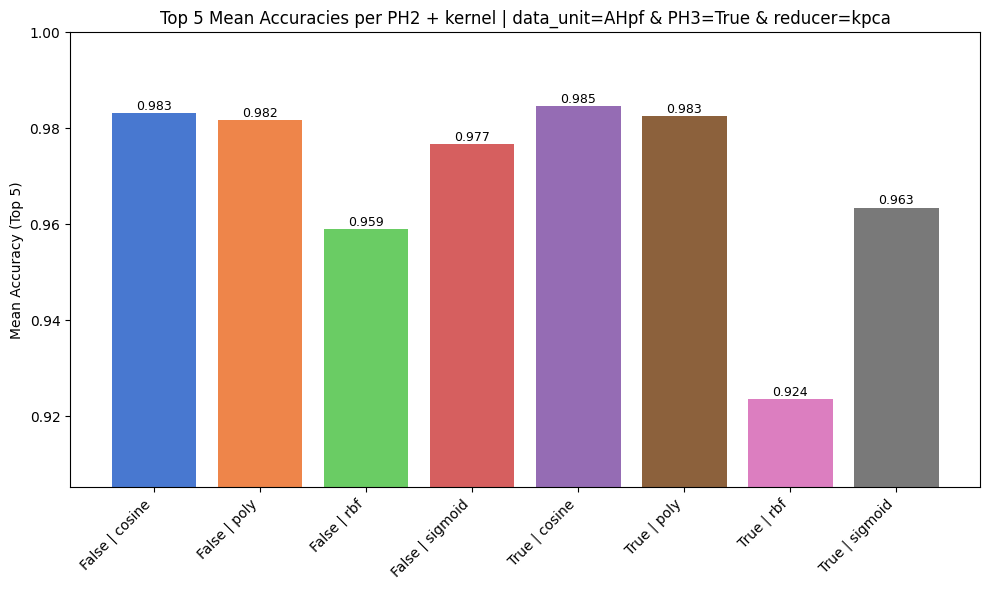

In [56]:
visualize(knn_scores_df, group_cols=['PH2', 'kernel'], top=top_barrier, filter_cols=['data_unit', 'PH3', 'reducer'], filter_values=[sup.DATA_AH_PF, True, 'kpca'])

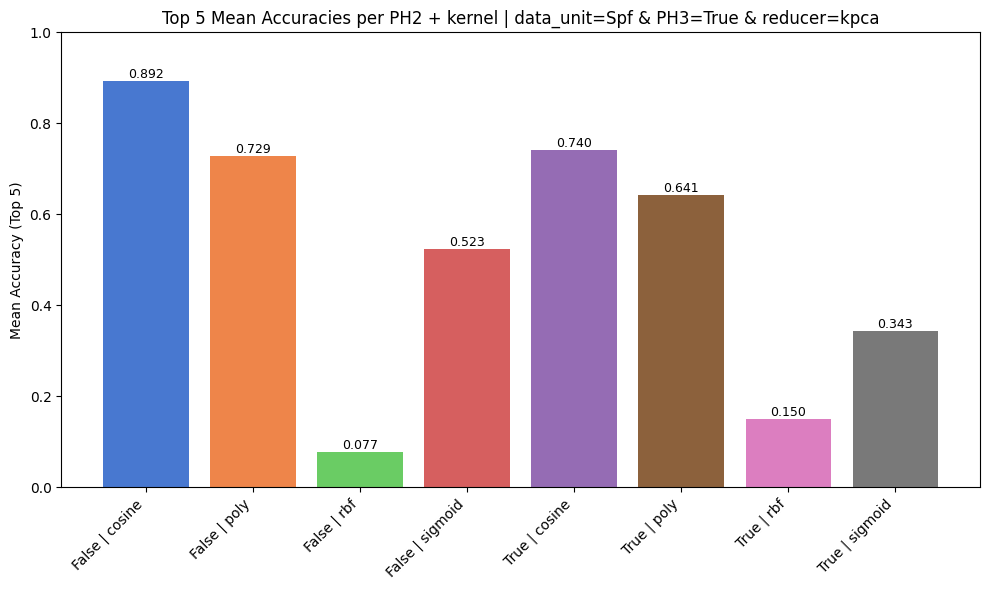

In [57]:
visualize(knn_scores_df, group_cols=['PH2', 'kernel'], top=top_barrier, filter_cols=['data_unit', 'PH3', 'reducer'], filter_values=[sup.DATA_S_PF, True, 'kpca'])

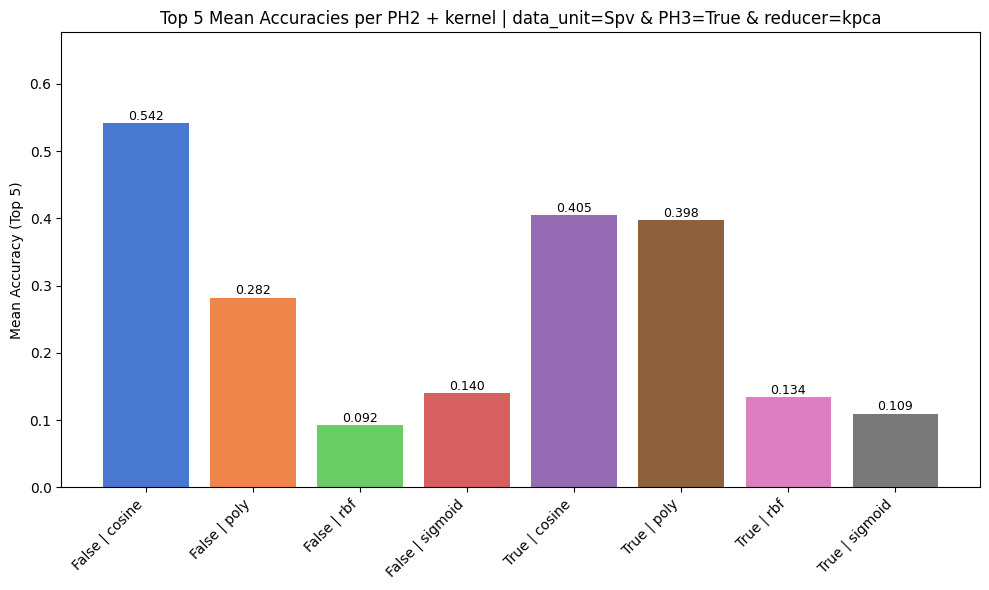

In [58]:
visualize(knn_scores_df, group_cols=['PH2', 'kernel'], top=top_barrier, filter_cols=['data_unit', 'PH3', 'reducer'], filter_values=[sup.DATA_S_PV, True, 'kpca'])

### By number of reduction components

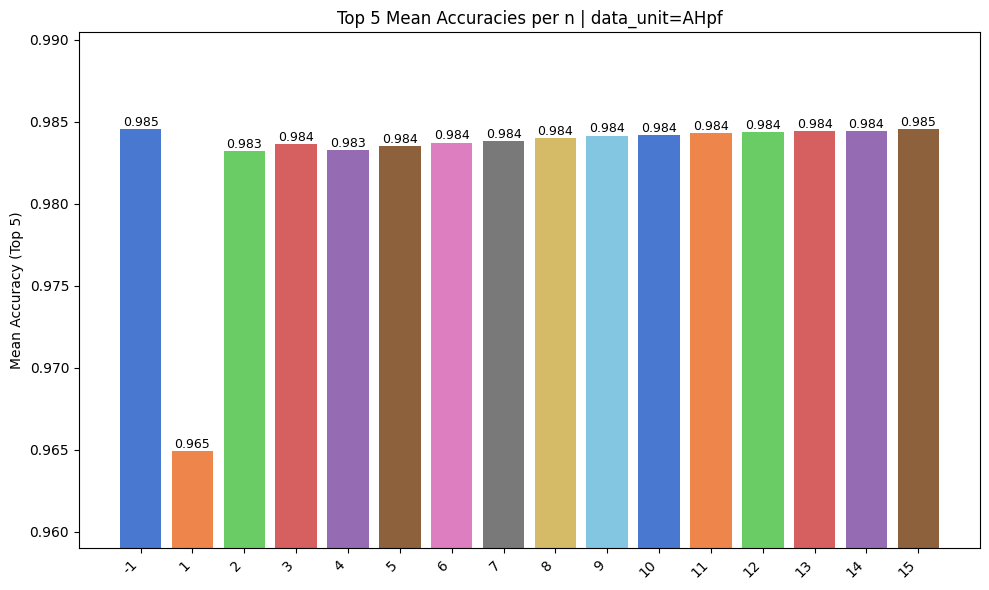

In [59]:
visualize(knn_scores_df, group_cols=['n'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

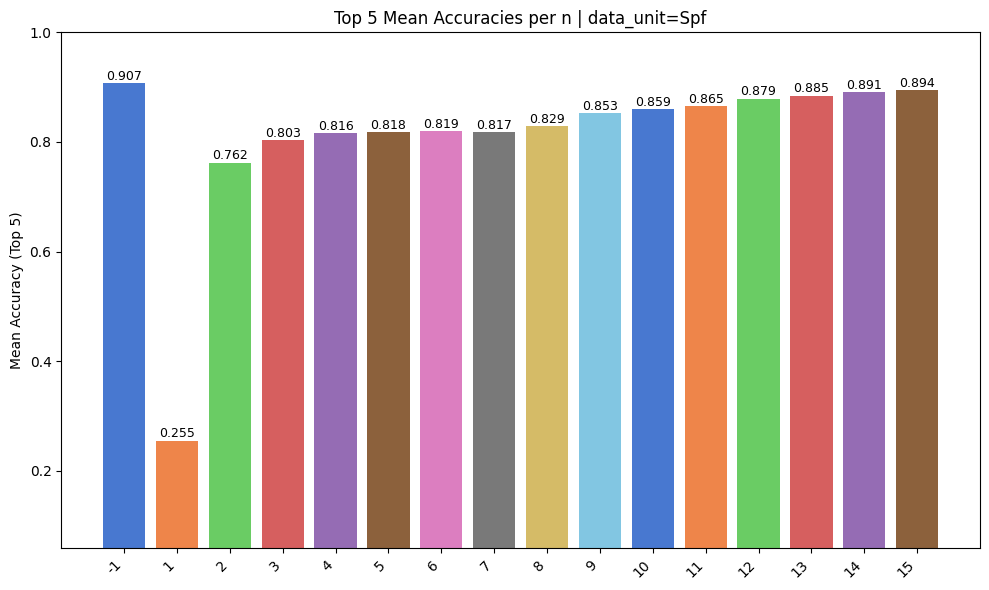

In [60]:
visualize(knn_scores_df, group_cols=['n'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

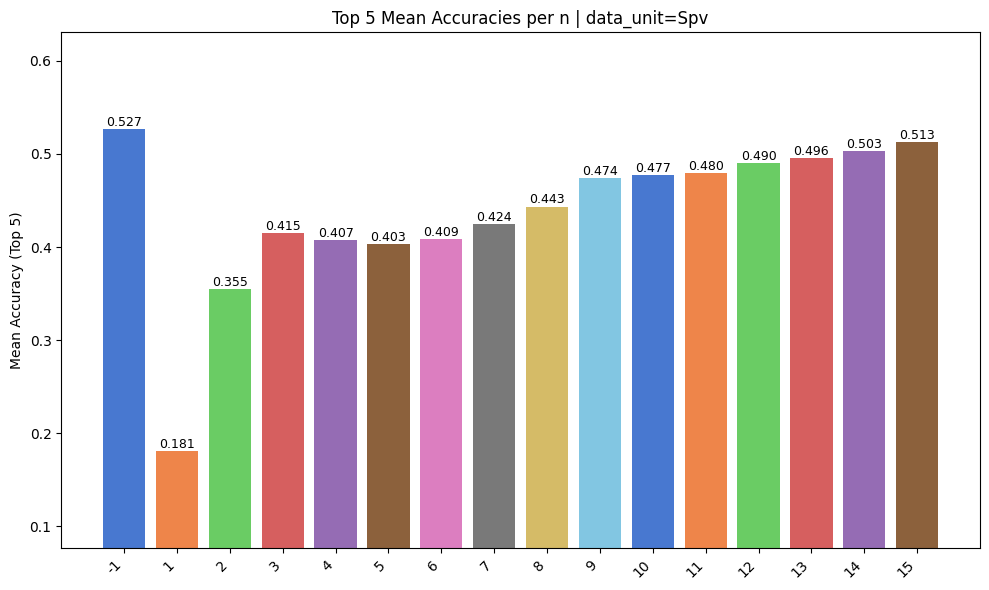

In [61]:
visualize(knn_scores_df, group_cols=['n'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

### By number of neighbors

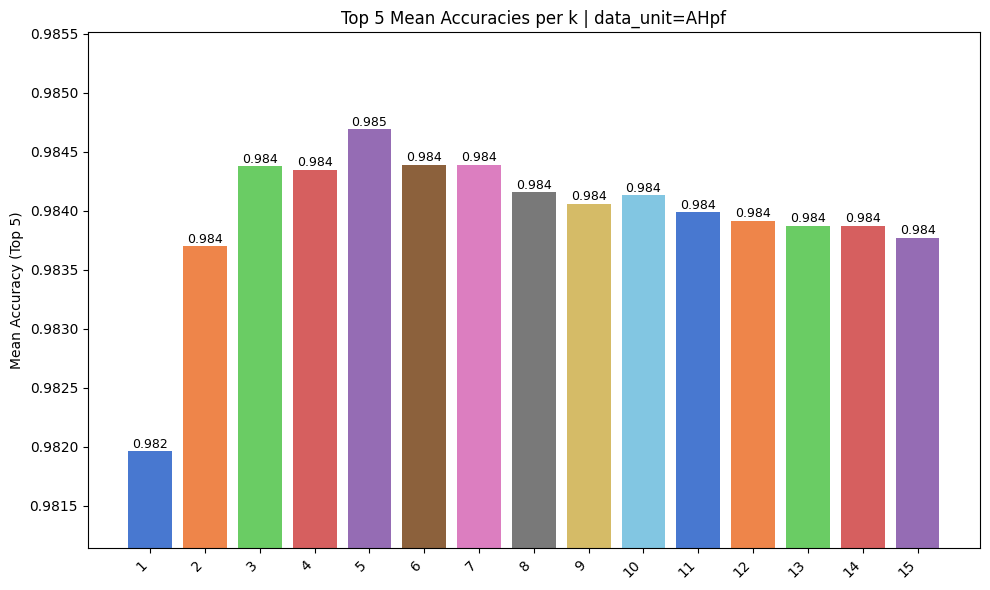

In [62]:
visualize(knn_scores_df, group_cols=['k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

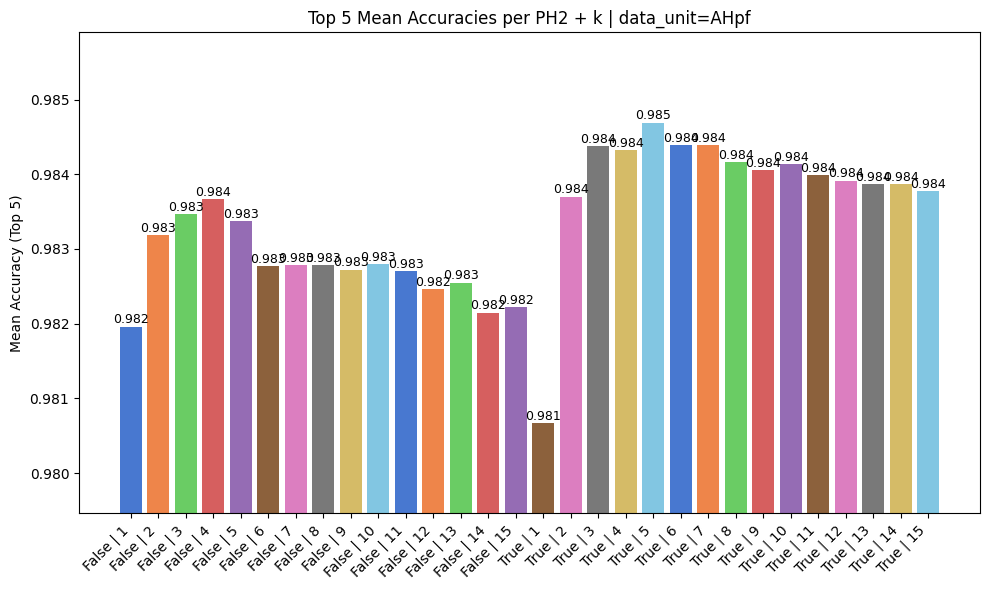

In [63]:
visualize(knn_scores_df, group_cols=['PH2', 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

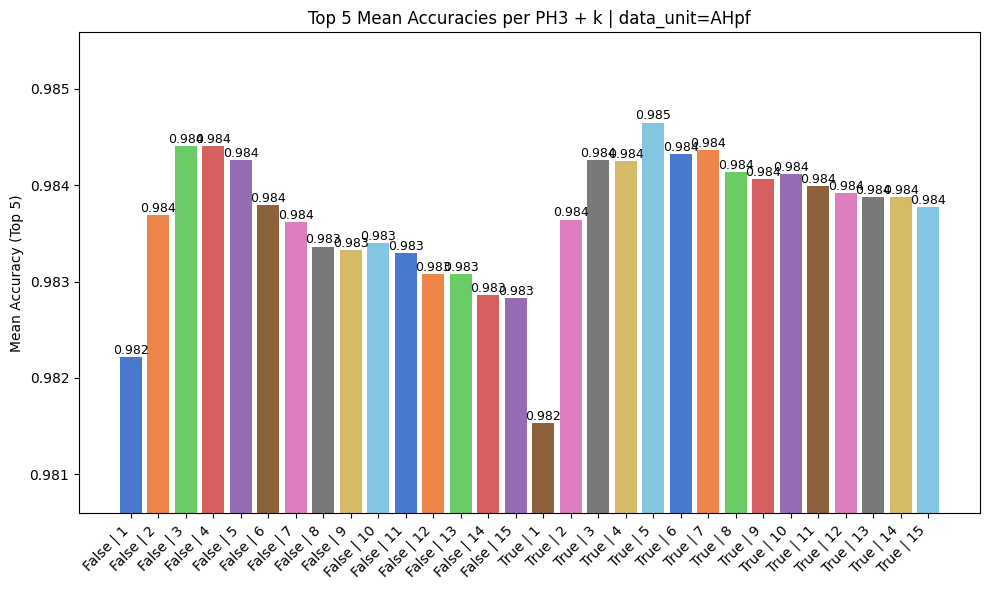

In [64]:
visualize(knn_scores_df, group_cols=['PH3', 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

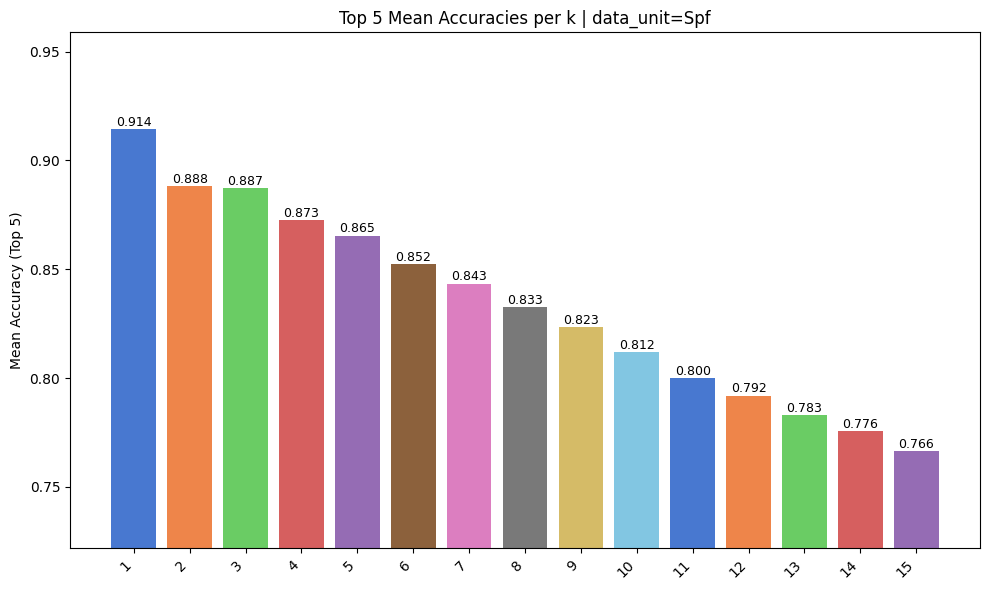

In [65]:
visualize(knn_scores_df, group_cols=['k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

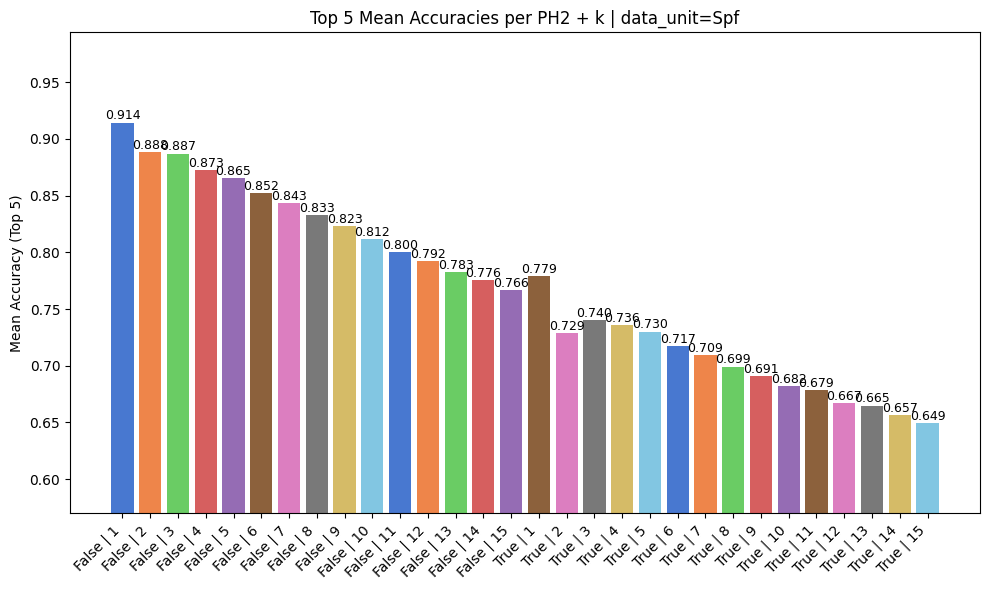

In [66]:
visualize(knn_scores_df, group_cols=['PH2', 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

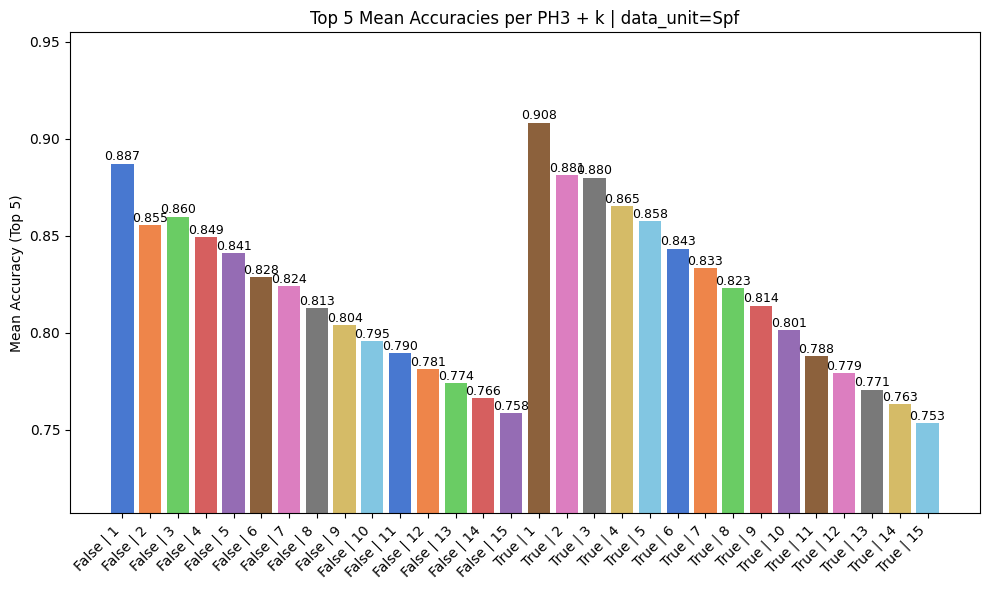

In [67]:
visualize(knn_scores_df, group_cols=['PH3', 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

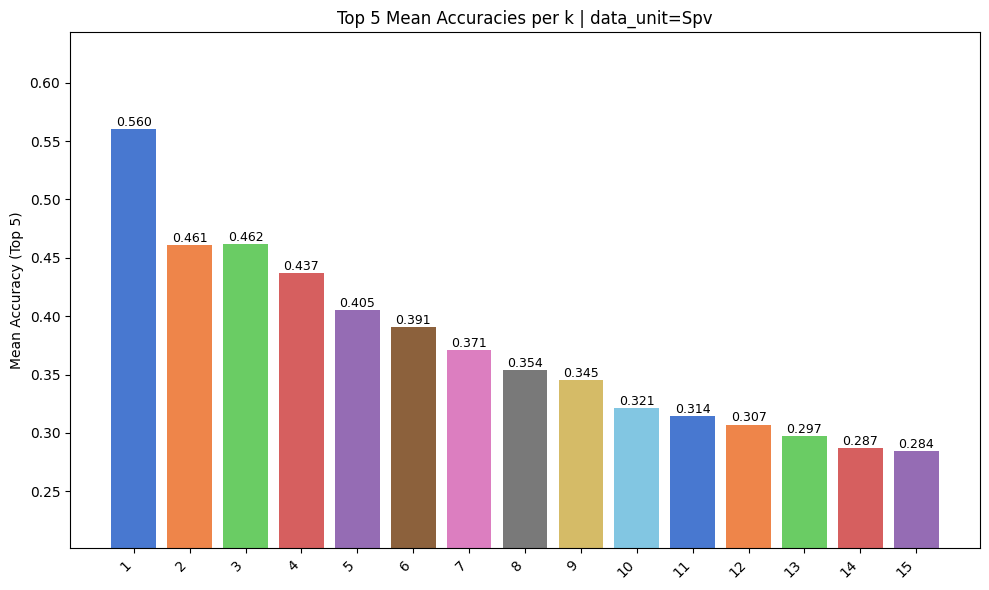

In [68]:
visualize(knn_scores_df, group_cols=[ 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

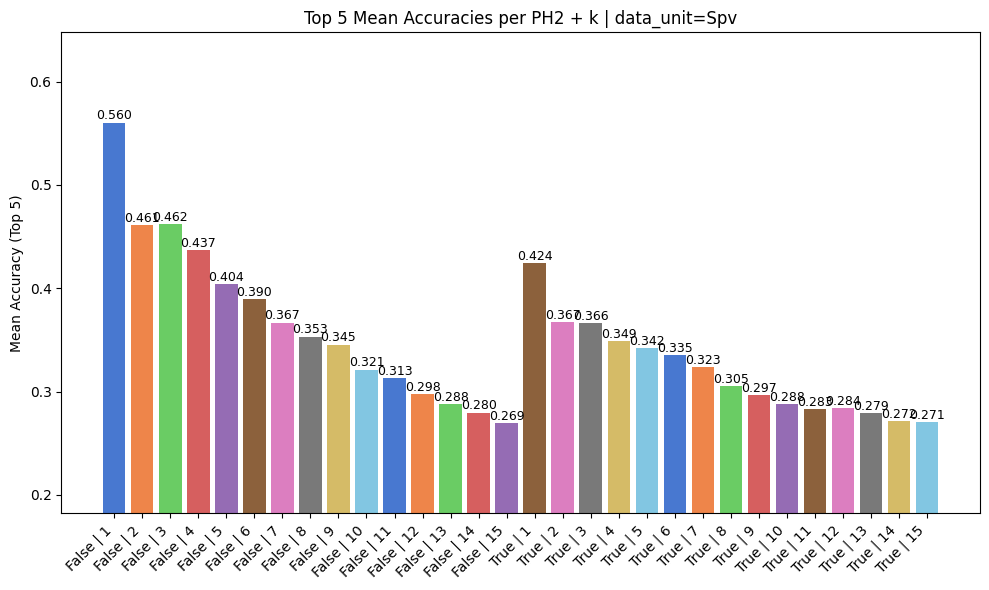

In [69]:
visualize(knn_scores_df, group_cols=['PH2', 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

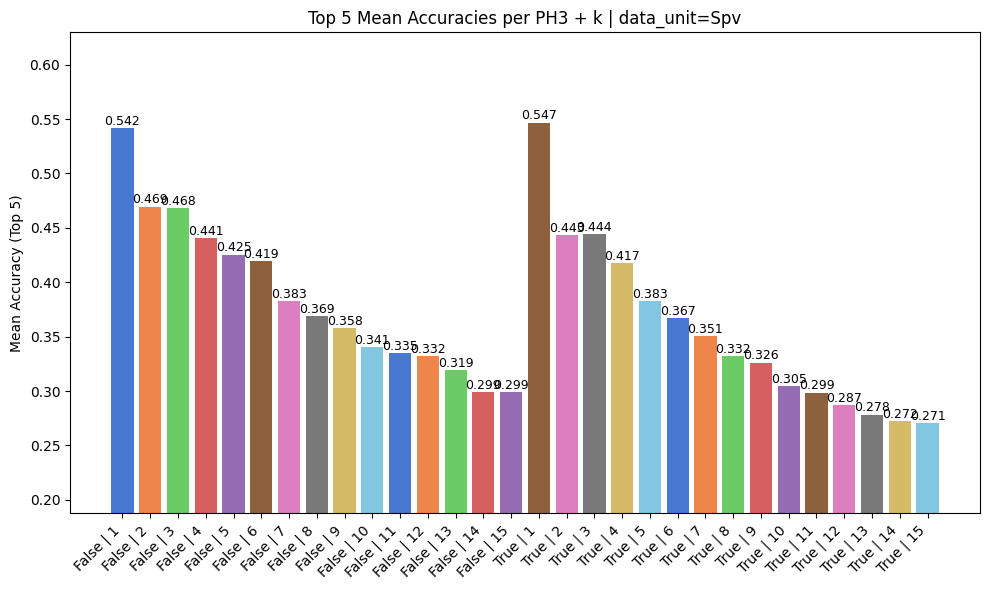

In [70]:
visualize(knn_scores_df, group_cols=['PH3', 'k'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])